<a href="https://colab.research.google.com/github/AmilcarArmmand/CSC-481_Project/blob/tim/BreakHis_481_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dropout, Rescaling,GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path="/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
batch_size = 16
image_size = 224,224
#preprocessing the image
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)



Mounted at /content/drive


In [3]:
# Separate validation generator with only rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
# Training data
train_data = train_datagen.flow_from_directory(
    file_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
validation_data = validation_datagen.flow_from_directory(
    file_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# class information
print(f"Classes found: {train_data.class_indices}")
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {validation_data.samples}")

Found 6328 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.
Classes found: {'benign': 0, 'malignant': 1}
Training samples: 6328
Validation samples: 1581


In [4]:
def create_model(base_model_type='DenseNet121'):
    if base_model_type == 'DenseNet121':
        base_model = DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_model_type == 'EfficientNetB3':
        base_model = EfficientNetB3(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_model_type == 'ResNet50V2':
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

    # top layers trainable
    for layer in base_model.layers[:-30]:  # Freeze most layers
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # you can try with different
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# model creating
model = create_model('DenseNet121')  # Options you may consider i am denseNet121: 'EfficientNetB3' or 'ResNet50V2'
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,332,929 (27.97 MB)

 Trainable params: 936,833 (3.57 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

##Train

In [5]:
#callbacks to prevent overfitting
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,  # Train longer with early stopping/ you can choose as you like
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6824 - auc: 0.6370 - loss: 0.6416 - precision: 0.7406 - recall: 0.8330
Epoch 1: val_accuracy improved from -inf to 0.75712, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 2499s 6s/step - accuracy: 0.6826 - auc: 0.6373 - loss: 0.6413 - precision: 0.7407 - recall: 0.8331 - val_accuracy: 0.7571 - val_auc: 0.7213 - val_loss: 0.5629 - val_precision: 0.7833 - val_recall: 0.8931 - learning_rate: 1.0000e-04
Epoch 2/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8660 - auc: 0.9194 - loss: 0.3309 - precision: 0.8847 - recall: 0.9248
Epoch 2: val_accuracy improved from 0.75712 to 0.77356, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 1627s 4s/step - accuracy: 0.8660 - auc: 0.9195 - loss: 0.3309 - precision: 0.8847 - recall: 0.9248 - val_accuracy: 0.7736 - val_auc: 0.8058 - val_loss: 0.5277 - val_precision: 0.7958 - val_recall: 0.9014 - learning_rate: 1.0000e-04
Epoch 3/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9024 - auc: 0.9515 - loss: 0.2563 - precision: 0.9153 - recall: 0.9429
Epoch 3: val_accuracy improved from 0.77356 to 0.80202, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 1625s 4s/step - accuracy: 0.9024 - auc: 0.9515 - loss: 0.2563 - precision: 0.9153 - recall: 0.9429 - val_accuracy: 0.8020 - val_auc: 0.8328 - val_loss: 0.5114 - val_precision: 0.8238 - val_recall: 0.9051 - learning_rate: 1.0000e-04
Epoch 4/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9244 - auc: 0.9686 - loss: 0.2016 - precision: 0.9371 - recall: 0.9546
Epoch 4: val_accuracy improved from 0.80202 to 0.81720, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 1665s 4s/step - accuracy: 0.9244 - auc: 0.9686 - loss: 0.2016 - precision: 0.9371 - recall: 0.9546 - val_accuracy: 0.8172 - val_auc: 0.8314 - val_loss: 0.5794 - val_precision: 0.8300 - val_recall: 0.9226 - learning_rate: 1.0000e-04
Epoch 5/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9211 - auc: 0.9694 - loss: 0.2067 - precision: 0.9363 - recall: 0.9480
Epoch 5: val_accuracy did not improve from 0.81720
396/396 ━━━━━━━━━━━━━━━━━━━━ 1635s 4s/step - accuracy: 0.9211 - auc: 0.9694 - loss: 0.2067 - precision: 0.9363 - recall: 0.9480 - val_accuracy: 0.8166 - val_auc: 0.8510 - val_loss: 0.6100 - val_precision: 0.8162 - val_recall: 0.9456 - learning_rate: 1.0000e-04
Epoch 6/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9344 - auc: 0.9791 - loss: 0.1698 - precision: 0.9473 - recall: 0.9575
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 6: val_accuracy improved from 0.81720 to 0.84377, saving model to best_m

396/396 ━━━━━━━━━━━━━━━━━━━━ 1628s 4s/step - accuracy: 0.9344 - auc: 0.9791 - loss: 0.1698 - precision: 0.9473 - recall: 0.9575 - val_accuracy: 0.8438 - val_auc: 0.8927 - val_loss: 0.5679 - val_precision: 0.8223 - val_recall: 0.9853 - learning_rate: 1.0000e-04
Epoch 7/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9420 - auc: 0.9827 - loss: 0.1484 - precision: 0.9541 - recall: 0.9619
Epoch 7: val_accuracy did not improve from 0.84377
396/396 ━━━━━━━━━━━━━━━━━━━━ 1646s 4s/step - accuracy: 0.9420 - auc: 0.9827 - loss: 0.1484 - precision: 0.9541 - recall: 0.9619 - val_accuracy: 0.8374 - val_auc: 0.8730 - val_loss: 0.5197 - val_precision: 0.8473 - val_recall: 0.9309 - learning_rate: 5.0000e-05
Epoch 8/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9468 - auc: 0.9849 - loss: 0.1429 - precision: 0.9596 - recall: 0.9628
Epoch 8: val_accuracy did not improve from 0.84377
396/396 ━━━━━━━━━━━━━━━━━━━━ 1613s 4s/step - accuracy: 0.9468 - auc: 0.9849 - loss: 0.1429 - precision: 

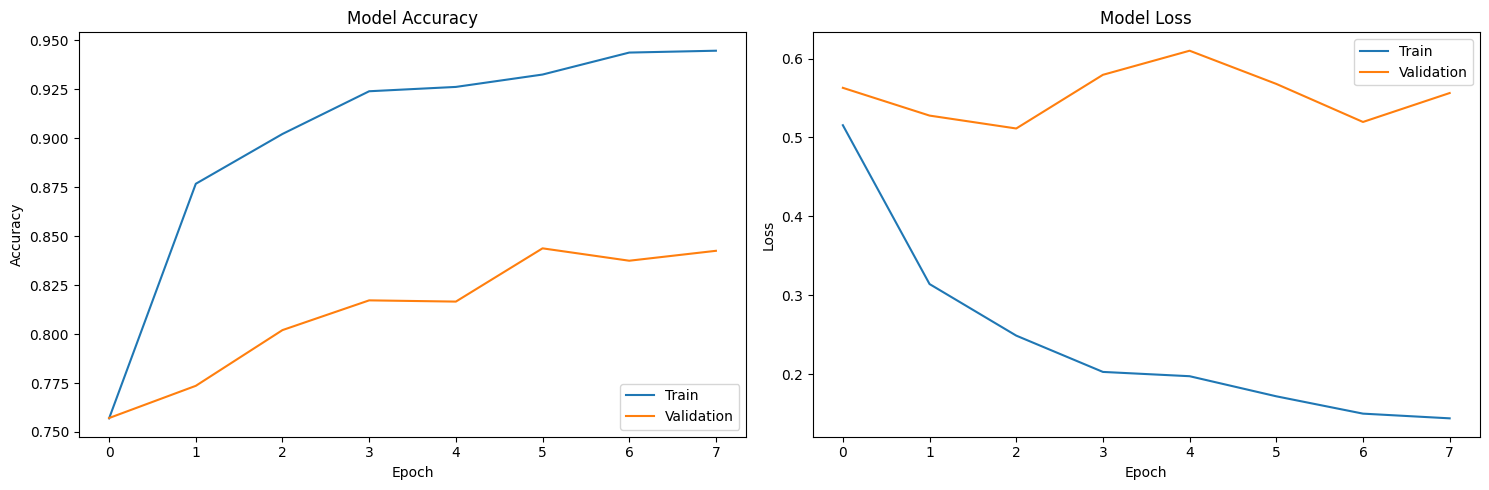

99/99 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.6814 - auc: 0.5481 - loss: 0.7979 - precision: 0.4322 - recall: 0.5884
Test accuracy: 0.8020
Test AUC: 0.8328
Test precision: 0.8238
Test recall: 0.9051


In [6]:
# Plot
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate the model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

In [7]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve_for_generator(model, data_generator):

    data_generator.reset()
    y_true = []
    y_pred = []

    num_batches = len(data_generator)

    for i in range(num_batches):
        x_batch, y_batch = data_generator[i]
        batch_pred = model.predict(x_batch)
        y_true.extend(y_batch)
        y_pred.extend(batch_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    return roc_auc


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2

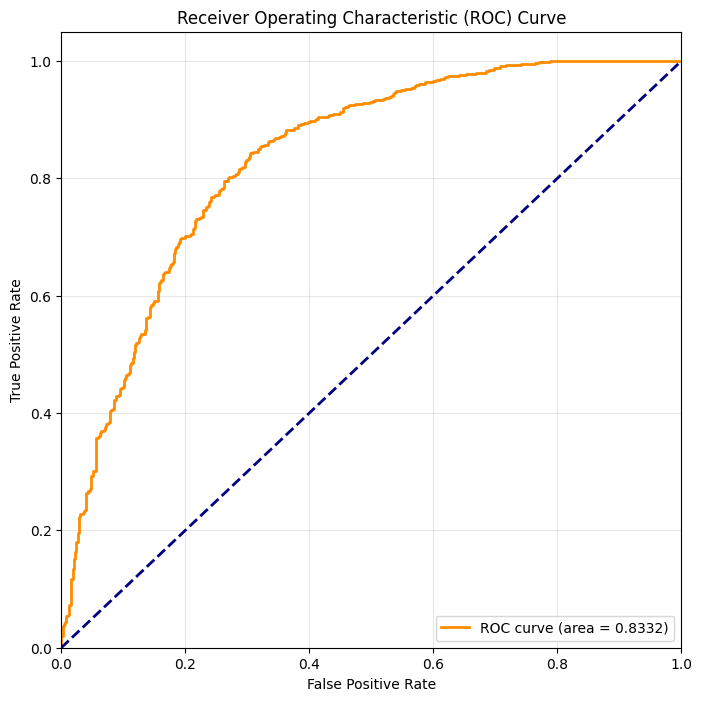

In [8]:
auc_score = plot_roc_curve_for_generator(model, validation_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


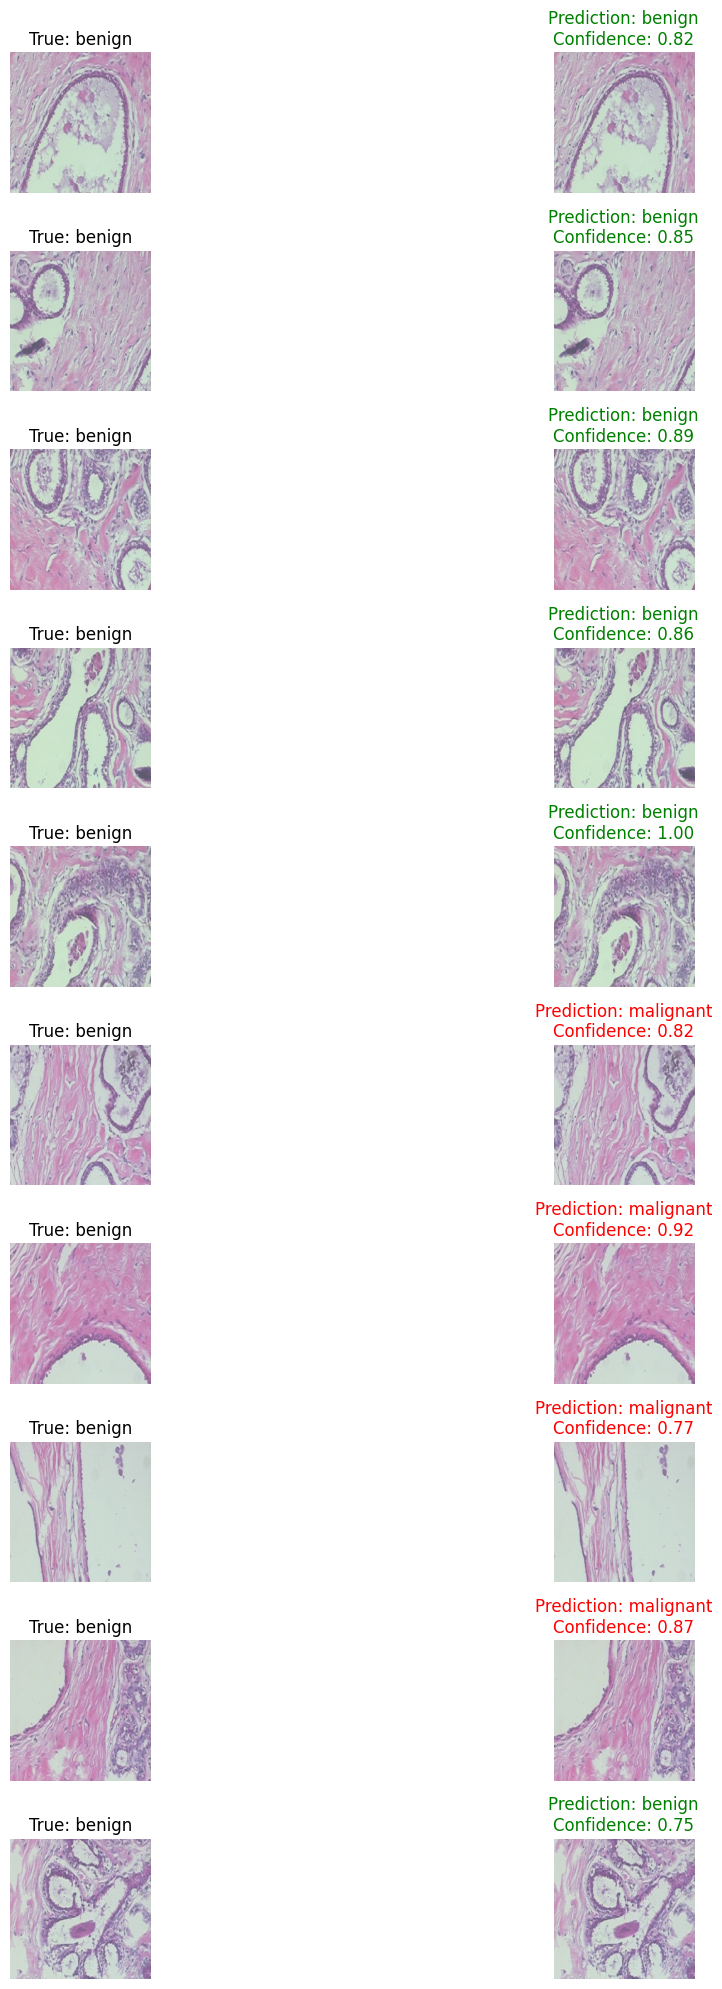

In [9]:

#model performance by visualization
def visualize_predictions(model, validation_data, num_images=10, class_names=None):

    validation_data.reset()

    if class_names is None:
        if hasattr(validation_data, 'class_indices'):

            class_names = {v: k for k, v in validation_data.class_indices.items()}
        else:

            class_names = {0: "Negative", 1: "Positive"}

    # Get a batch of images
    images_seen = 0
    plt.figure(figsize=(15, num_images * 2))

    # Process images batch by batch
    for i, (batch_images, batch_labels) in enumerate(validation_data):

        batch_preds = model.predict(batch_images)

        # For each image in the batch
        for j in range(len(batch_images)):
            if images_seen >= num_images:
                break

            #image, true label, and predicted label
            img = batch_images[j]
            true_label = batch_labels[j]

            #different prediction out of 1
            if len(batch_preds.shape) > 1 and batch_preds.shape[1] > 1:

                pred_label = np.argmax(batch_preds[j])
                pred_confidence = batch_preds[j][pred_label]
            else:

                pred_score = batch_preds[j][0] if len(batch_preds.shape) > 1 else batch_preds[j]
                pred_label = 1 if pred_score > 0.5 else 0
                pred_confidence = pred_score if pred_label == 1 else 1 - pred_score


            if isinstance(true_label, np.ndarray) and len(true_label.shape) > 0:
                true_label = np.argmax(true_label)

            true_class = class_names.get(true_label, f"Class {true_label}")
            pred_class = class_names.get(pred_label, f"Class {pred_label}")

            #image and prediction
            plt.subplot(num_images, 2, images_seen * 2 + 1)

            if np.max(img) <= 1.0:
                display_img = img * 255
            else:
                display_img = img

            if display_img.shape[-1] == 1:
                plt.imshow(display_img.reshape(display_img.shape[0], display_img.shape[1]), cmap='gray')
            else:
                plt.imshow(display_img.astype('uint8'))

            plt.title(f"True: {true_class}", fontsize=12)
            plt.axis('off')

            plt.subplot(num_images, 2, images_seen * 2 + 2)

            if display_img.shape[-1] == 1:
                plt.imshow(display_img.reshape(display_img.shape[0], display_img.shape[1]), cmap='gray')
            else:
                plt.imshow(display_img.astype('uint8'))

            color = "green" if pred_label == true_label else "red"
            plt.title(f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}",
                      fontsize=12, color=color)
            plt.axis('off')

            images_seen += 1

        if images_seen >= num_images:
            break

    plt.tight_layout()
    plt.show()

visualize_predictions(model, validation_data, num_images=10)

